In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from pandas.plotting import table

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [7]:
df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

100%|██████████| 30408/30408 [00:58<00:00, 516.53it/s]


In [8]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("last")["position"]

C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\3272273204.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\3272273204.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["last_position"] = billboard_hot_100.sort_values(


In [9]:
billboard_hot_100_copy = billboard_hot_100.copy()
billboard_hot_100 = billboard_hot_100.groupby(
    ["artist", "song_name"])["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "year", "first_position", "last_position"].first().reset_index()

C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\4046987392.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100 = billboard_hot_100.groupby(


In [10]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]

## Clustering the songs based on the features

In [11]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

scaler = StandardScaler()
X = scaler.fit_transform(billboard_hot_100[features])

model = KMeans(n_clusters=5, n_init="auto", random_state=1)
model.fit(X)

y_clusters = model.predict(X)

In [12]:
billboard_hot_100["cluster"] = y_clusters
billboard_hot_100_new = billboard_hot_100[["artist", "song_name", "cluster"]].merge(billboard_hot_100_copy, on=["artist", "song_name"], how="left")

In [13]:
from numpy import unique

unique_clusters = unique(y_clusters)

In [14]:
# classify clusters
cluster_statistics = {}

for cluster in unique_clusters:
    songs_from_cluster = billboard_hot_100_new[billboard_hot_100_new['cluster'] == cluster].copy()
    cluster_statistics[cluster] = songs_from_cluster[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()

brief_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
start_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["first_position"] for i in unique_clusters])
end_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["future_weeks"] for i in unique_clusters])
normal_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
longlasting_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
print("Brief " + str(brief_cluster))
print("High start " + str(start_high_cluster))
print("High end " + str(end_high_cluster))
print("Normal " + str(normal_cluster))
print("Longlasting " + str(longlasting_cluster))

Brief 4
High start 1
High end 2
Normal 0
Longlasting 3


In [15]:
def map_cluster_name(cluster_nr):
    if cluster_nr == brief_cluster:
        return "Brief songs"
    if cluster_nr == start_high_cluster:
        return "High start songs"
    if cluster_nr == end_high_cluster:
        return "High end songs"
    if cluster_nr == normal_cluster:
        return "Climbing flow songs"
    return "Long-lasting songs"

billboard_hot_100_new["cluster"] = billboard_hot_100_new["cluster"].map(lambda x: map_cluster_name(x))

In [16]:
rows_to_add = []

grouped = billboard_hot_100_new.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + timedelta(weeks=1)

            while week <= (max_week + timedelta(weeks=50)):
                rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_position": row["first_position"],
                    "last_position": row["last_position"],
                    "past_weeks": row["past_weeks"],
                    "future_weeks": row["future_weeks"],
                    "max_weeks_on_chart": row["max_weeks_on_chart"],
                    "cluster": row["cluster"],
                    "year": row["year"]
                })
                week += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100_new[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "top_position",
    "first_position", "last_position", "past_weeks", "future_weeks",
    "max_weeks_on_chart", "cluster", "year"]], pd.DataFrame(rows_to_add)], ignore_index=True)
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

100%|██████████| 30091/30091 [01:58<00:00, 254.46it/s]


## Functions for simplicity

In [17]:
def average_trajectories(cluster, xlim):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
    row_i, col_i = 0, 0
    cluster_songs = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster]

    for decade in tqdm(range(1960, 2020, 10)):
        songs_from_decade = cluster_songs[(cluster_songs['year'] >= decade) &\
                                        (cluster_songs['year'] < decade + 10)].copy()
            
        min_first_week = songs_from_decade["first_day_of_the_week"].min().to_pydatetime()
        songs_from_decade["first_day_of_the_week"] = songs_from_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        songs_from_decade.set_index("first_day_of_the_week", inplace=True)
        songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()

        axes[row_i, col_i].plot(songs_from_decade.groupby("first_day_of_the_week")["position"].mean(),
                marker='o', ms=5)
            
        axes[row_i, col_i].text(0.7, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=11)
        if row_i == 2 or ((row_i == 1) and (col_i == 1)):
            axes[row_i, col_i].set_xlabel("Week")
            axes[row_i, col_i].xaxis.set_tick_params(labelbottom=True)
            axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(6))
            for tk in axes[row_i, col_i].get_xticklabels():
                    tk.set_visible(True)

        if col_i == 0:
            axes[row_i, col_i].set_ylabel("Position")

        col_i += 1
        if col_i == 2:
            col_i = 0
            row_i += 1

    cluster_name = cluster.replace(" ", "_").lower()
    plt.xlim(0, xlim)
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/average_clusters_{cluster_name}_over_time.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [18]:
def trajectories(cluster, xlim):

    fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
    row_i, col_i = 0, 0
    cluster_songs = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster]

    for decade in tqdm(range(1960, 2020, 10)):
        songs_from_decade = cluster_songs[(cluster_songs['year'] >= decade) &\
                                        (cluster_songs['year'] < decade + 10)].copy()
            
        min_first_week = songs_from_decade["first_day_of_the_week"].min().to_pydatetime()

        songs_from_decade["first_day_of_the_week"] = songs_from_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        songs_from_decade = songs_from_decade[songs_from_decade["first_day_of_the_week"] < 80]
        songs_from_decade.set_index("first_day_of_the_week", inplace=True)
        songs_from_decade.sort_index(inplace=True)

        first_2000_songs = [g[1] for g in list(songs_from_decade.groupby(["artist", "song_name"]))[:1000]]
        for song in tqdm(first_2000_songs):
            songs_series = song["position"]
            axes[row_i, col_i].plot(songs_series.index, songs_series.values, alpha=0.02, color="C0")
            
        axes[row_i, col_i].text(0.7, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=11)
        if row_i == 2 or ((row_i == 1) and (col_i == 1)):
            axes[row_i, col_i].set_xlabel("Week")
            axes[row_i, col_i].xaxis.set_tick_params(labelbottom=True)
            axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(6))
            for tk in axes[row_i, col_i].get_xticklabels():
                tk.set_visible(True)

        if col_i == 0:
            axes[row_i, col_i].set_ylabel("Position")

        col_i += 1
        if col_i == 2:
            col_i = 0
            row_i += 1

    cluster_name = cluster.replace(" ", "_").lower()
    plt.xlim(0, xlim)
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/trajectories_{cluster_name}_over_time.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Differences in Brief songs over time

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 17%|█▋        | 1/6 [00:04<00:21,  4.36s/it]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 33%|███▎      | 2/6 [00:07<00:13,  3.37s/it]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of

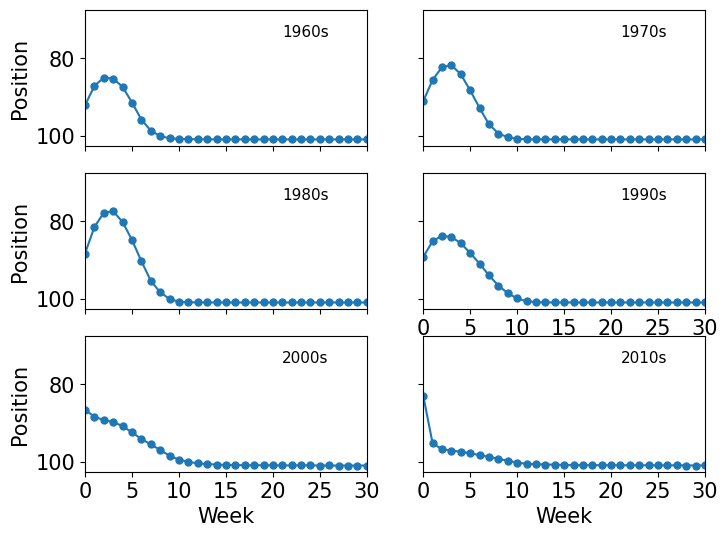

In [19]:
average_trajectories("Brief songs", 30)

100%|██████████| 6/6 [00:21<00:00,  3.50s/it]


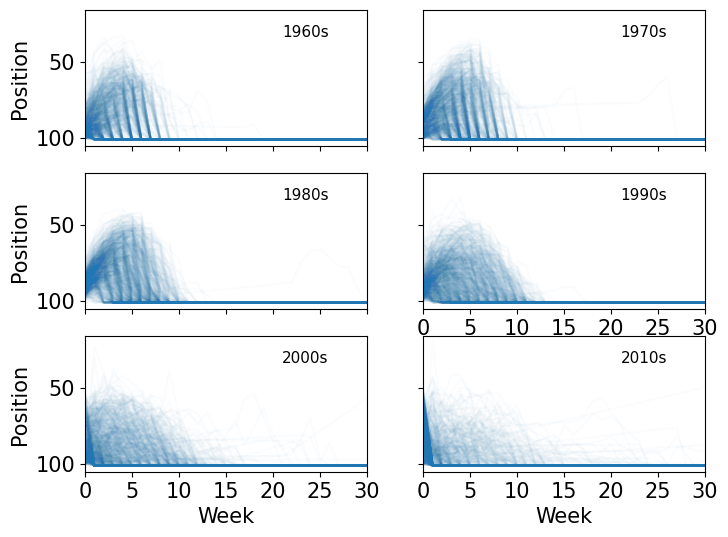

In [20]:
trajectories("Brief songs", 30)

## Differences in Climbing flow songs over time

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 17%|█▋        | 1/6 [00:00<00:01,  3.49it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 33%|███▎      | 2/6 [00:01<00:04,  1.11s/it]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of

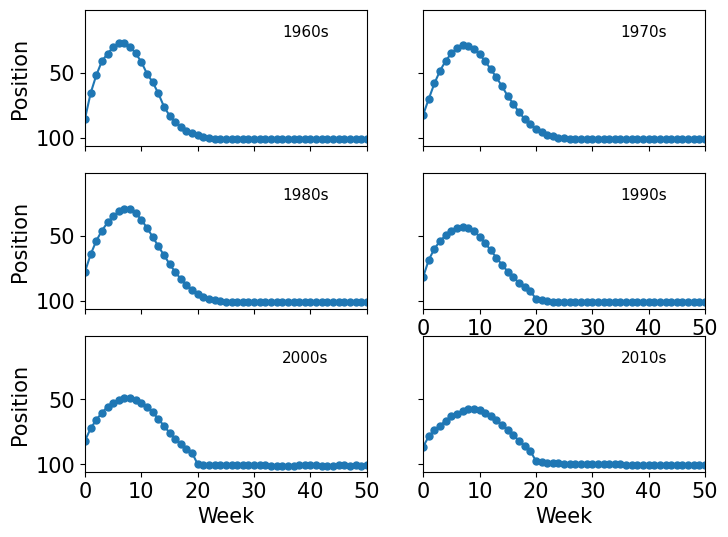

In [21]:
average_trajectories("Climbing flow songs", 50)

100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


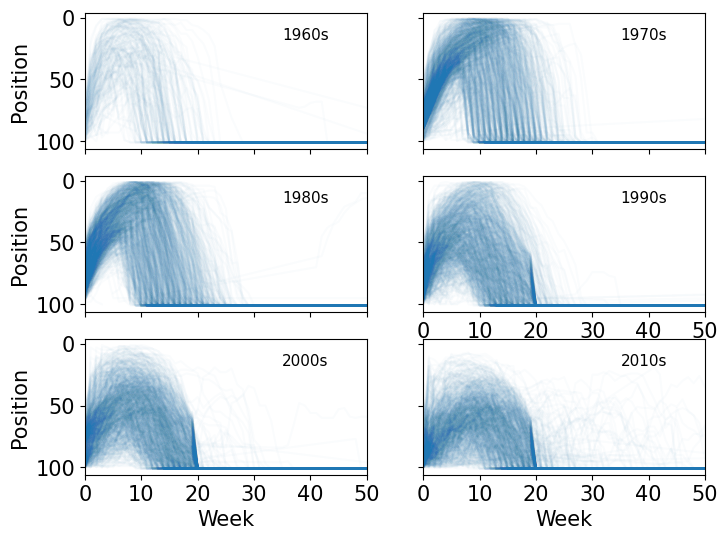

In [22]:
trajectories("Climbing flow songs", 50)

## Differences in High end songs over time

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 17%|█▋        | 1/6 [00:04<00:23,  4.64s/it]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 33%|███▎      | 2/6 [00:07<00:14,  3.70s/it]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of

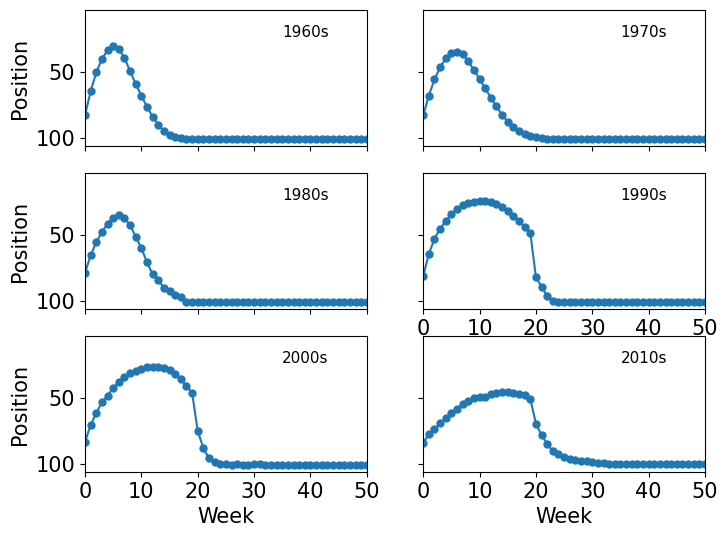

In [23]:
average_trajectories("High end songs", 50)

100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


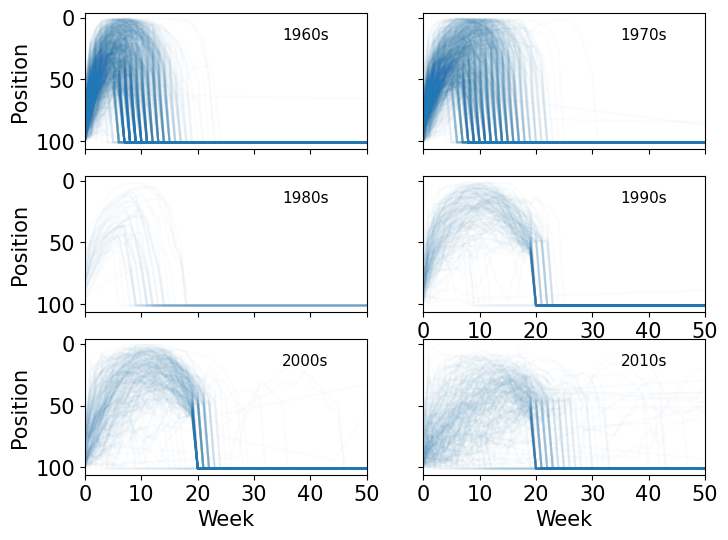

In [24]:
trajectories("High end songs", 50)

## Differences in High start songs over time

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 17%|█▋        | 1/6 [00:00<00:00,  9.93it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is dep

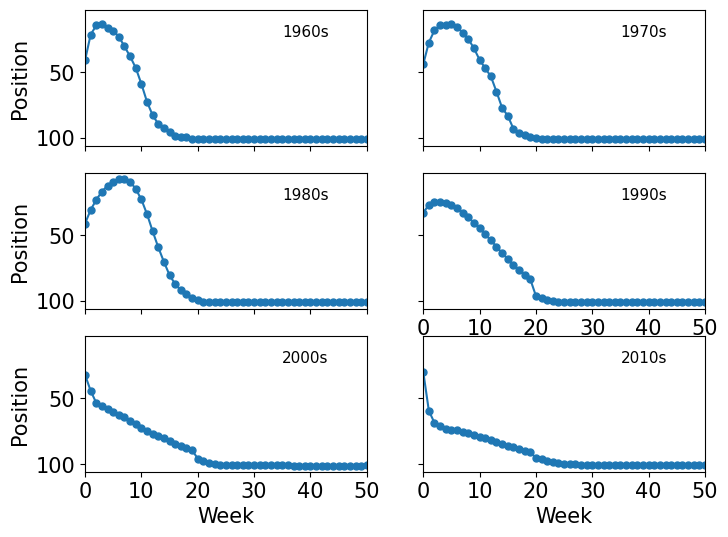

In [25]:
average_trajectories("High start songs", 50)

100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


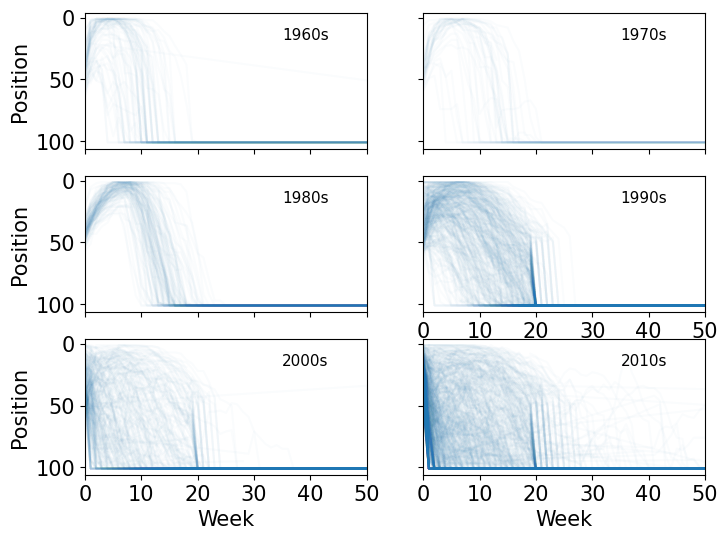

In [26]:
trajectories("High start songs", 50)

## Differences in Long-lasting songs over time

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_from_decade = songs_from_decade.groupby("first_day_of_the_week").mean()
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]C:\Users\cutie\AppData\Local\Temp\ipykernel_25240\2117531854.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is dep

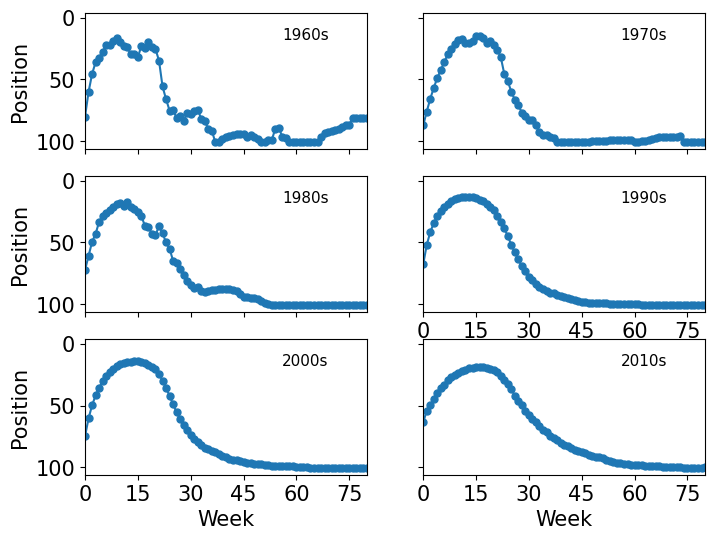

In [27]:
average_trajectories("Long-lasting songs", 80)

100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


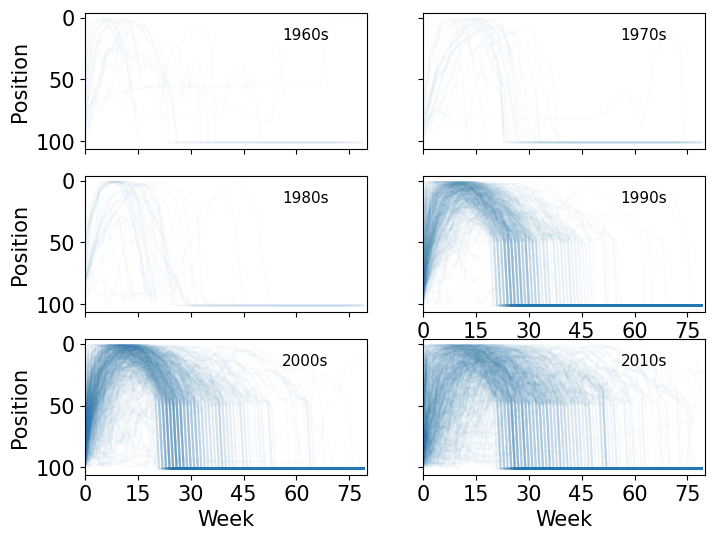

In [28]:
trajectories("Long-lasting songs", 80)